# Logging to a file

## Overview

### Questions

* What is a Logger?
* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Describe and give examples of **loggable quantities**.
* Show how to add quantities to a **Logger**.
* Demonstrate **HDF5Log** as a log writer.
* Explain how to read logged quantities from **HDF5** files.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate code

In [1]:
import hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import os

fn = os.path.join(os.getcwd(), 'log.h5')
![ -e "$fn" ] && rm "$fn"

## Introduction

HOOMD separates logging into three parts: **Loggable quantities**, the **Logger** class, and 
**Writers**.

* **Loggable quantities** are values computed during a simulation.
* The **Logger** class provides a way to collect and name quantities of interest.
* **Writers** write these values out in a format you can later use.

In this section, you will use the **HDF5Log Writer** to capture the values of quantities during a simulation run for later analysis.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(
    filename='../01-Introducing-Molecular-Dynamics/random.gsd'
)

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator
simulation.run(0)

## Loggable quantities

Many classes in HOOMD-blue provide special *properties* called **loggable quantities**.
For example, the **Simulation** class provides `timestep`, `tps`, and others.
The reference documentation labels each of these as _Loggable_.
You can also examine the ``loggables`` property to determine the **loggable quantities**:

In [4]:
simulation.loggables

{'timestep': 'scalar',
 'seed': 'scalar',
 'tps': 'scalar',
 'walltime': 'scalar',
 'final_timestep': 'scalar',
 'initial_timestep': 'scalar'}

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [5]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar',
 'volume': 'scalar'}

**Loggable quantities** are class properties or methods.
You can directly access them in your code.

In [6]:
simulation.timestep

10000

In [7]:
thermodynamic_properties.kinetic_temperature

1.5950485725069867

Each **loggable quantity** has a **category**, which is listed both in the reference documentation and in ``loggables``.
The **category** is a string that identifies the quantity's type or category.
Example categories include:
* `scalar` - numbers
* `sequence` - arrays of numbers
* `string` - strings of characters
* `particle` - arrays of per-particle values

## Add quantities to a Logger

Add each of the quantities you would like to store to a **Logger**.
The **Logger** will maintain these quantities in a list and provide them to the **Writer** when needed.

In [8]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])

You can add **loggable quantities** from any number of objects to a **Logger**.
**Logger** uses the namespace of the class to assign a unique name for each quantity.
Call `add` to add all quantities provided by `thermodynamic_properties`:

In [9]:
logger.add(thermodynamic_properties)

You can also select specific quantities to add with the `quantities` argument.
Add only the `timestep` and `walltime` quantities from **Simulation**:

In [10]:
logger.add(simulation, quantities=['timestep', 'walltime'])

## Writing log quantities to a file

Use the **HDF5Log** writer to store the quantities provided by `logger` to a HDF5 (`.h5`) file.

In [11]:
hdf5_writer = hoomd.write.HDF5Log(
    trigger=hoomd.trigger.Periodic(1000), filename='log.h5', mode='x', logger=logger
)
simulation.operations.writers.append(hdf5_writer)

The writer triggers and writes to the log file when the simulation runs:

In [12]:
simulation.run(100_000)

Remove the writer from the simulation to close the file:

<div class="alert alert-info">
This step is not necessary in typical workflows where a simulation script writes a log file and exits before a later analysis script reads the file.
</div>

In [13]:
simulation.operations.writers.remove(hdf5_writer)

## Reading logged data from a HDF5 file

HDF5 is a **binary** file format. You must use tools that support the format to access the file. The HDF5 library provides command line tools to examine the file contents interactively. `h5ls` lists the datasets in the file:

<div class="alert alert-info">
In Jupyter, the “!” magic command is equivalent to typing the given command in a shell.
</div>

In [14]:
!h5ls -r log.h5

/                        Group
/hoomd-data              Group
/hoomd-data/Simulation   Group
/hoomd-data/Simulation/timestep Dataset {100/Inf}
/hoomd-data/Simulation/walltime Dataset {100/Inf}
/hoomd-data/md           Group
/hoomd-data/md/compute   Group
/hoomd-data/md/compute/ThermodynamicQuantities Group
/hoomd-data/md/compute/ThermodynamicQuantities/degrees_of_freedom Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/kinetic_energy Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/num_particles Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/pressure Dataset {100/Inf}
/hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor Dataset {100/Inf, 6}
/hoomd-data/md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom Dataset {100/Inf}
/hoomd-data/md/compute/Thermo

The datasets have verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy`.

`h5dump` writes the contents of HDF5 files in a human readable form:

In [15]:
!h5dump -d /hoomd-data/md/compute/ThermodynamicQuantities/potential_energy log.h5

HDF5 "log.h5" {
DATASET "/hoomd-data/md/compute/ThermodynamicQuantities/potential_energy" {
   DATATYPE  H5T_IEEE_F64LE
   DATASPACE  SIMPLE { ( 100 ) / ( H5S_UNLIMITED ) }
   DATA {
   (0): -549.5, -534.66, -562.199, -532.078, -521.426, -523.534, -573.096,
   (7): -552.695, -542.698, -549.952, -537.796, -541.976, -516.883, -558.729,
   (14): -575.244, -533.639, -525.093, -545.14, -545.206, -548.099, -521.61,
   (21): -544.652, -541.47, -522.255, -560.74, -535.493, -541.011, -551.586,
   (28): -538.912, -540.738, -523.334, -566.458, -535.875, -544.828,
   (34): -529.365, -562.823, -521.96, -546.935, -537.666, -541.428, -545.243,
   (41): -538.271, -543.778, -540.597, -544.284, -528.809, -530.586,
   (47): -558.172, -556.267, -541.073, -536.747, -536.548, -553.082,
   (53): -535.615, -559.795, -554.16, -556.978, -540.011, -542.222, -549.045,
   (60): -528.408, -574.476, -525.855, -523.335, -512.41, -531.369, -545.768,
   (67): -548.647, -538.825, -535.903, -530.557, -523.248, -536.899,


Use the `h5py` package to read HDF5 files in Python:

In [16]:
import h5py

hdf5_file = h5py.File(name='log.h5', mode='r')

Index into the file object similar to a dictionary:

In [17]:
hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/potential_energy']

<HDF5 dataset "potential_energy": shape (100,), type "<f8">

Access the dataset entries with a slice:

In [18]:
hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/potential_energy'][:]

array([-549.50004456, -534.65954933, -562.19940801, -532.07796683,
       -521.42631261, -523.53375423, -573.09643309, -552.6951781 ,
       -542.69799226, -549.95206692, -537.79572697, -541.97590863,
       -516.8829588 , -558.7288184 , -575.24413581, -533.63876624,
       -525.09271675, -545.14010356, -545.20552317, -548.09914698,
       -521.6095112 , -544.65210537, -541.47038337, -522.25454976,
       -560.73999882, -535.49296435, -541.01102005, -551.58613024,
       -538.91187621, -540.7380379 , -523.33390383, -566.45818603,
       -535.87523795, -544.82806967, -529.36498716, -562.82257838,
       -521.96022067, -546.93453583, -537.66567604, -541.4283643 ,
       -545.24312931, -538.27078084, -543.77810022, -540.59698295,
       -544.28380948, -528.80853503, -530.58576773, -558.17155034,
       -556.26674128, -541.07294335, -536.74691314, -536.54788188,
       -553.0819941 , -535.61504188, -559.79482215, -554.15950136,
       -556.97767311, -540.01119137, -542.22202165, -549.04463

Use a `h5py` dataset slice wherever you would normally use NumPy arrays. For example, plot the time series data:

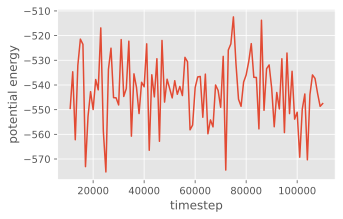

In [19]:
timestep = hdf5_file['hoomd-data/Simulation/timestep'][:]
potential_energy = hdf5_file[
    'hoomd-data/md/compute/ThermodynamicQuantities/potential_energy'
][:]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig

`HDF5Log` writes sequence, particle, bond, etc... quantities in addition to scalers. For example, the pressure tensor is a 6 element array on each frame:

In [22]:
hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor'][0]

array([ 0.14391669, -0.01012993, -0.04182644,  0.25004318,  0.00844331,
        0.30558124])

In this section, you have logged quantities to a file during a simulation run and analyzed that data as a time series.
The next section of this tutorial shows you how to save per-particle quantities associated with specific system configurations.

[Index](00-index.ipynb) / [Next section](02-Saving-Array-Quantities.ipynb).